# Behavioral Trends Analysis:

Identify for which behavioral questions (Question_1 to Question_10) the responses change significantly between:

- Self-Tested individuals (Relation_to_test = Self)
- Assisted-Tested individuals (Relation_to_test ≠ Self)
  
  
Goal: Highlight patterns where assisted responses differ significantly from self-responses.

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [2]:
output_folder = "visualizations"

## Step 1: Data Preparation

- Load the cleaned_data.csv.
- Split the dataset into two groups:
    - Self-Tested: Relation_to_test == "Self"
    - Assisted-Tested: Relation_to_test != "Self"

In [3]:
# load the dataset
data_path = '../data/cleaned_data.csv'
df = pd.read_csv(data_path)

# split the data into Self-Tested and Assisted-Tested groups
self_tested = df[df['Relation_to_test'].str.lower() == 'self'].copy()
assisted_tested = df[df['Relation_to_test'].str.lower() != 'self'].copy()

# print the sizes of the two groups
print(f"Total number of records: {len(df)}")
print(f"Number of Self-Tested individuals: {len(self_tested)}")
print(f"Number of Assisted-Tested individuals: {len(assisted_tested)}")

Total number of records: 609
Number of Self-Tested individuals: 522
Number of Assisted-Tested individuals: 87


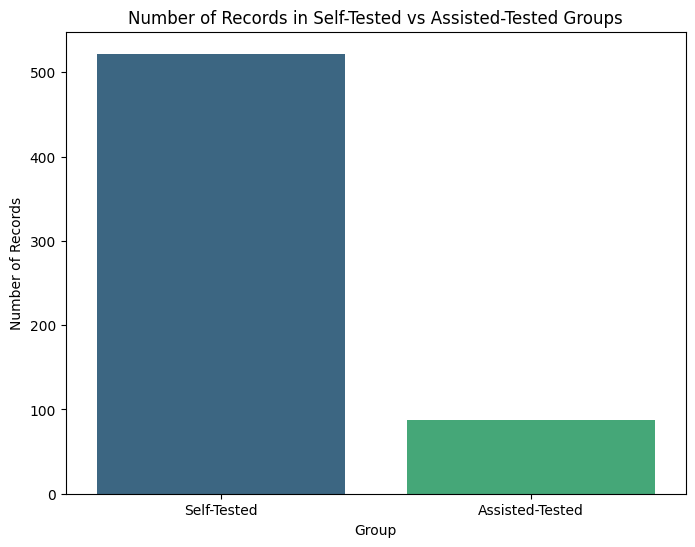

In [4]:
# bar chart for group sizes
group_data = pd.DataFrame({
    'Group': ['Self-Tested', 'Assisted-Tested'],
    'Count': [len(self_tested), len(assisted_tested)]
})

plt.figure(figsize=(8, 6))
sns.barplot(data=group_data, x="Group", y="Count", hue="Group", palette='viridis', legend=False)
plt.title("Number of Records in Self-Tested vs Assisted-Tested Groups")
plt.ylabel("Number of Records")
plt.xlabel("Group")
plt.savefig(os.path.join(output_folder, "group_size_bar_chart.png"),  bbox_inches='tight')
plt.show()
plt.close()

## Step 2

The next step is Behavioral Trends Analysis, where we compare the responses to behavioral questions (`Question_1` to `Question_10`) between the Self-Tested and Assisted-Tested groups to identify significant differences.

Goal: For each behavioral question (`Question_1` to `Question_10`), compare how responses differ between the two groups.
Highlight questions where the responses vary significantly.

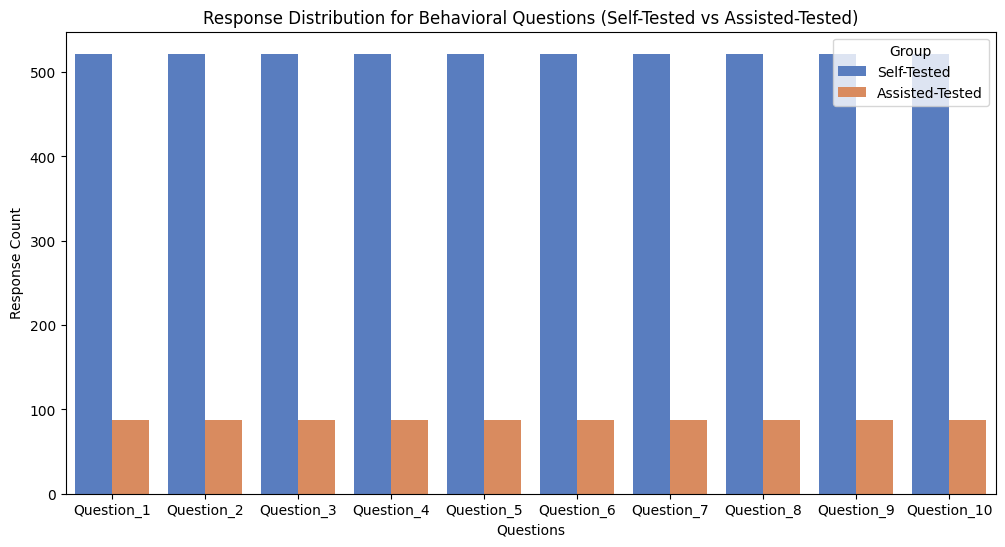

In [5]:
# melt the dataset to long format for easy plotting
melted_self = self_tested.melt(
    id_vars=["Relation_to_test"], 
    value_vars=[f"Question_{i}" for i in range(1, 11)],
    var_name="Question", value_name="Response"
)
melted_self["Group"] = "Self-Tested"

melted_assisted = assisted_tested.melt(
    id_vars=["Relation_to_test"], 
    value_vars=[f"Question_{i}" for i in range(1, 11)],
    var_name="Question", value_name="Response"
)
melted_assisted["Group"] = "Assisted-Tested"

# combine the two groups into one DataFrame
combined_df = pd.concat([melted_self, melted_assisted])

# plot the response distribution for each question
plt.figure(figsize=(12, 6))
sns.countplot(
    data=combined_df, 
    x="Question", 
    hue="Group", 
    palette="muted", 
    dodge=True
)

# add titles and labels
plt.title("Response Distribution for Behavioral Questions (Self-Tested vs Assisted-Tested)")
plt.xlabel("Questions")
plt.ylabel("Response Count")
plt.legend(title="Group")

# show the plot
plt.show()


### Interpretation of Response Distribution Chart

- The chart shows the total response count for each behavioral question (`Question_1` to `Question_10`) across two groups:
  - **Self-Tested**: Individuals who completed the test themselves.
  - **Assisted-Tested**: Individuals who were assisted by others (e.g., parents, caregivers).

**Observations**:
  - The **Self-Tested** group has significantly more responses for every question, as indicated by the taller bars.
  - The **Assisted-Tested** group has much smaller counts due to fewer participants.
  - This imbalance highlights the need for further analysis to determine whether the response trends (`0` and `1`) differ between the two groups.

Next, we will explore the detailed response distributions for `0` and `1` and statistically test for significant differences.


<Figure size 1400x1200 with 0 Axes>

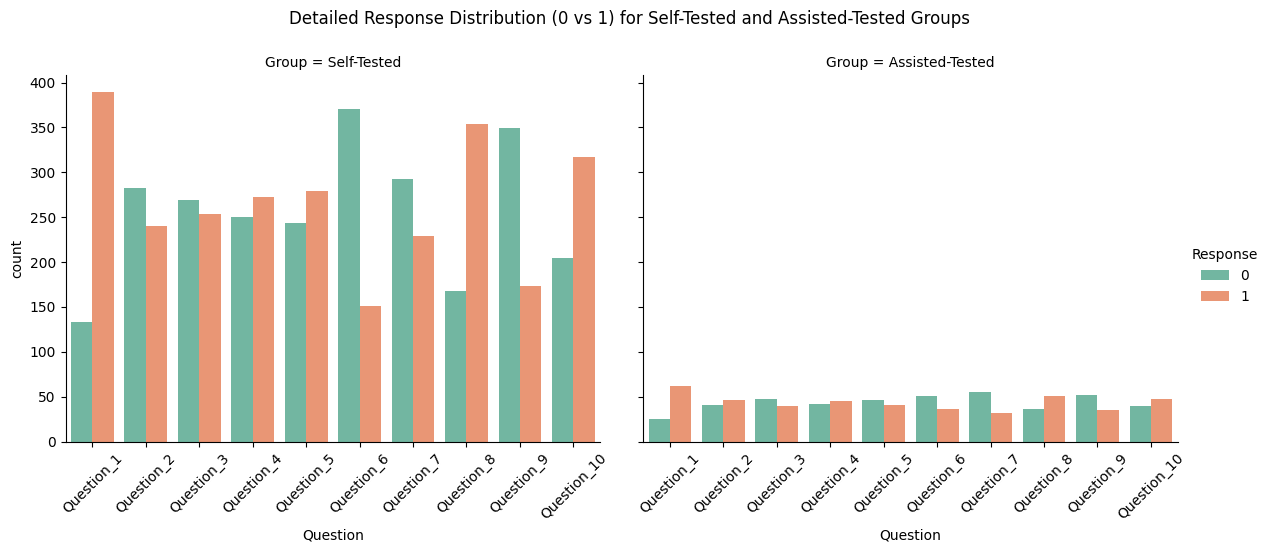

In [6]:
# Create a faceted count plot for detailed comparison
plt.figure(figsize=(14, 12))
g = sns.catplot(
    data=combined_df,
    x="Question",
    hue="Response",
    col="Group",
    kind="count",
    palette="Set2",
    height=5,
    aspect=1.2
)

# Adjust spacing and rotate x-axis labels
g.set_xticklabels(rotation=45)
g.fig.subplots_adjust(top=0.85)  # Adjust layout
g.fig.suptitle("Detailed Response Distribution (0 vs 1) for Self-Tested and Assisted-Tested Groups")
plt.savefig(os.path.join(output_folder, "response_distribution.png"),  bbox_inches='tight')
plt.show()
plt.close()

### Interpretation of Detailed Response Distribution Chart

- **Self-Tested Group**:
  - Clear response trends for certain questions:
    - **Question_1**: Majority of responses are `1`.
    - **Question_6**: Majority of responses are `0`.
    - **Question_8**: Majority of responses are `1`.
    - **Questions 2, 3, 4, 5, 7**: Balanced distribution of `0` and `1`.
  - Overall, responses show more variability.

- **Assisted-Tested Group**:
  - Fewer participants lead to shorter bars.
  - Responses are more evenly split between `0` and `1` across all questions.
  - Less pronounced trends compared to the Self-Tested group.

## Step 3

Perform Chi-Square to determine if these differences are significant.

In [7]:
# questions to analyze
questions = [f"Question_{i}" for i in range(1, 11)]

# placeholder for results
chi_square_results = []

# combine the data for analysis
self_tested["Group"] = "Self-Tested"
assisted_tested["Group"] = "Assisted-Tested"
combined_cleaned = pd.concat([self_tested, assisted_tested])

# perform Chi-Square Test for each question
for question in questions:
    # create contingency table for each question
    contingency_table = pd.crosstab(
        combined_cleaned[question],  # rows: Responses (0/1)
        combined_cleaned['Group']    # columns: Group (Self-Tested or Assisted-Tested)
    )

    # perform the Chi-Square Test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # store results
    chi_square_results.append({
        'Question': question,
        'Chi-Square': chi2,
        'p-value': p
    })

# convert results to DataFrame
chi_square_df = pd.DataFrame(chi_square_results)

# display results
print("Chi-Square Test Results:")
display(chi_square_df)

# highlight significant results
significant_questions = chi_square_df[chi_square_df['p-value'] < 0.05]
print("\nQuestions with Significant Differences (p < 0.05):")
display(significant_questions)

Chi-Square Test Results:


,Question,Chi-Square,p-value
0,Question_1,0.259597,0.610397
1,Question_2,1.160551,0.281351
2,Question_3,0.098937,0.753109
3,Question_4,0.000000,1.000000
4,Question_5,0.955129,0.328417
5,Question_6,4.864769,0.027410
6,Question_7,1.254111,0.262769
7,Question_8,2.432769,0.118823
8,Question_9,1.365677,0.242556
9,Question_10,1.129327,0.287919



Questions with Significant Differences (p < 0.05):


,Question,Chi-Square,p-value
5,Question_6,4.864769,0.02741


### Chi-Square Test Results

We performed the **Chi-Square Test of Independence** to determine if responses to each behavioral question differ significantly between the **Self-Tested** and **Assisted-Tested** groups.


#### Key Observation:
- **Question 6** has a statistically significant difference (p-value = **0.02741**) between the **Self-Tested** and **Assisted-Tested** groups. This indicates that the response patterns for Question 6 are **not independent** between the two groups.

#### Implications:
- Question 6 might reflect differences in how individuals respond when self-testing versus being assisted. Further investigation could explore why these differences arise and their impact on ASD screening accuracy.


## Model Training and Evaluation: Overview

We aim to compare the accuracy of models trained on Self-Tested and Assisted-Tested groups.

First try logistic regression

In [8]:
# Function to perform cross-validation
def logistic_regression_cv(data, group_name):
    X = data[features]
    y = data[target]
    
    # Stratified K-Fold ensures balanced class distribution across folds
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Initialize Logistic Regression model
    model = LogisticRegression(max_iter=1000)
    
    # Perform cross-validation
    accuracy = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
    precision = cross_val_score(model, X, y, cv=skf, scoring='precision')
    recall = cross_val_score(model, X, y, cv=skf, scoring='recall')
    f1 = cross_val_score(model, X, y, cv=skf, scoring='f1')
    
    # Display results
    print(f"Cross-Validation Results for {group_name} Group:")
    print(f"Accuracy: {np.mean(accuracy):.4f} ± {np.std(accuracy):.4f}")
    print(f"Precision: {np.mean(precision):.4f} ± {np.std(precision):.4f}")
    print(f"Recall: {np.mean(recall):.4f} ± {np.std(recall):.4f}")
    print(f"F1-Score: {np.mean(f1):.4f} ± {np.std(f1):.4f}")
    print("-" * 50)

    return model

features = [f"Question_{i}" for i in range(1, 11)]
target = "ASD_Class"

# Split the data into Self-Tested and Assisted-Tested groups
self_tested_data = self_tested[features + [target]]
assisted_tested_data = assisted_tested[features + [target]]

# Perform cross-validation for Self-Tested group
print("Running Logistic Regression with Cross-Validation for Self-Tested Group...")
model_self_tested = logistic_regression_cv(self_tested_data, "Self-Tested")

# Perform cross-validation for Assisted-Tested group
print("Running Logistic Regression with Cross-Validation for Assisted-Tested Group...")
model_assisted_tested = logistic_regression_cv(assisted_tested_data, "Assisted-Tested")

Running Logistic Regression with Cross-Validation for Self-Tested Group...
Cross-Validation Results for Self-Tested Group:
Accuracy: 0.9981 ± 0.0038
Precision: 0.9938 ± 0.0125
Recall: 1.0000 ± 0.0000
F1-Score: 0.9968 ± 0.0063
--------------------------------------------------
Running Logistic Regression with Cross-Validation for Assisted-Tested Group...
Cross-Validation Results for Assisted-Tested Group:
Accuracy: 0.9654 ± 0.0283
Precision: 1.0000 ± 0.0000
Recall: 0.8700 ± 0.1077
F1-Score: 0.9270 ± 0.0607
--------------------------------------------------


### Cross-Validation Results: Logistic Regression

#### **1. Self-Tested Group**
- The model performs exceptionally well for the Self-Tested group with near-perfect metrics.
- The minimal standard deviation indicates consistent performance across all folds.
- The Recall of **1.0000** means the model is perfectly capturing all positive cases (ASD_Class = 1).


#### **2. Assisted-Tested Group**
- While the model still performs well for the Assisted-Tested group, the results are slightly lower compared to the Self-Tested group.  
- Precision remains perfect (1.0000), but Recall drops to **0.8700**, meaning some positive cases (ASD_Class = 1) are missed.  
- The higher standard deviation for Recall and F1-Score indicates less consistency across folds, likely due to the smaller dataset size.


### **Key Insights**
1. **Performance Difference**:
   - The model achieves near-perfect performance on the **Self-Tested group**, with higher Recall and F1-Score.
   - Performance for the **Assisted-Tested group** is slightly lower, especially in Recall, indicating that the model struggles to generalize as well with fewer samples.

2. **Possible Causes**:
   - The Assisted-Tested group has a much **smaller sample size**, which may limit the model’s ability to learn patterns effectively.
   - Overfitting could still be a factor in the Self-Tested group due to its near-perfect scores.

3. **Implications**:
   - Assistance may introduce variability in responses, which affects the model’s consistency.
   - The Self-Tested group provides more stable patterns, possibly due to higher sample size or clearer self-reported behavior.


## Decision Tree

Running Decision Tree for Self-Tested Group...
Decision Tree Cross-Validation Results for Self-Tested Group:
Accuracy: 0.9328 ± 0.0317
Precision: 0.8529 ± 0.0635
Recall: 0.9421 ± 0.0556
F1-Score: 0.8941 ± 0.0510
--------------------------------------------------
Feature Importance:
Question_1: 0.0322
Question_2: 0.0521
Question_3: 0.0628
Question_4: 0.0783
Question_5: 0.1463
Question_6: 0.0939
Question_7: 0.0598
Question_8: 0.0391
Question_9: 0.3966
Question_10: 0.0389


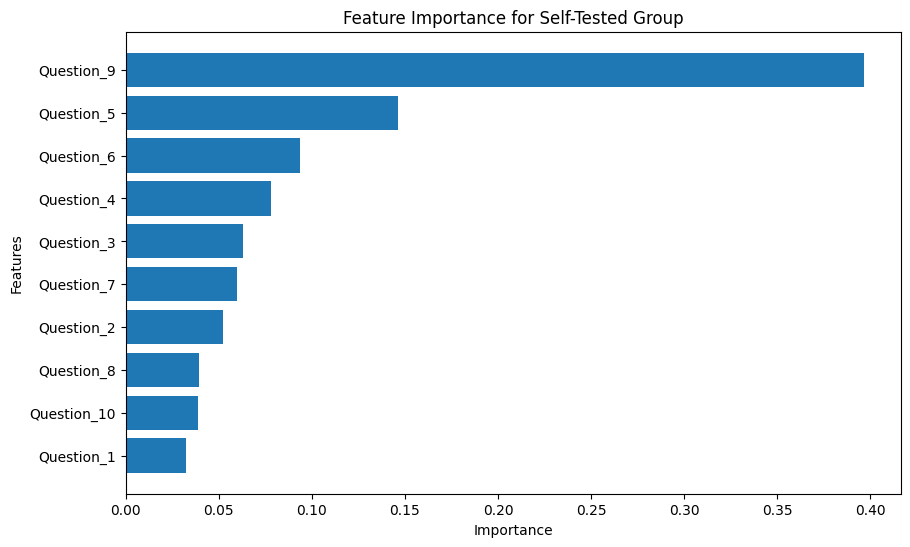

--------------------------------------------------
Running Decision Tree for Assisted-Tested Group...
Decision Tree Cross-Validation Results for Assisted-Tested Group:
Accuracy: 0.8732 ± 0.0250
Precision: 0.7962 ± 0.1141
Recall: 0.7700 ± 0.2750
F1-Score: 0.7267 ± 0.1638
--------------------------------------------------
Feature Importance:
Question_1: 0.0296
Question_2: 0.0148
Question_3: 0.1013
Question_4: 0.0148
Question_5: 0.0510
Question_6: 0.0458
Question_7: 0.0000
Question_8: 0.0957
Question_9: 0.5339
Question_10: 0.1132


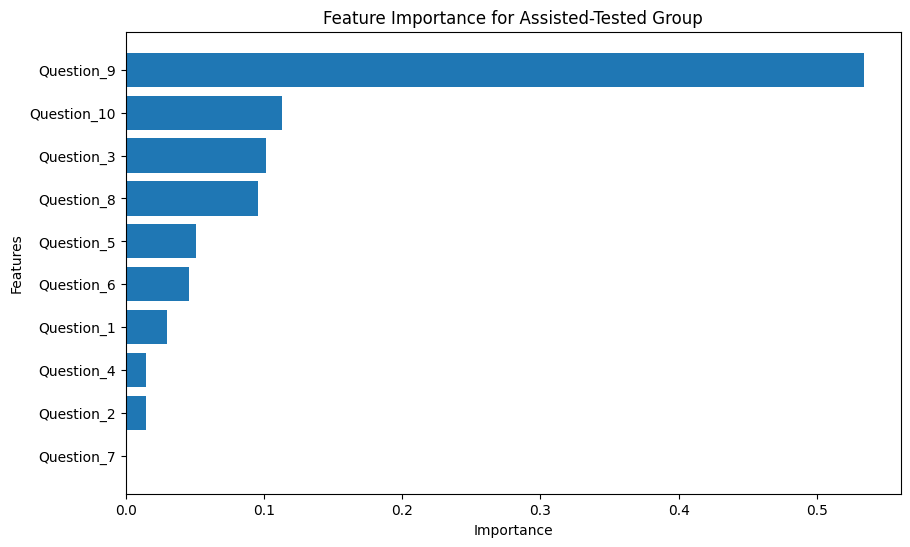

--------------------------------------------------


In [9]:
# Function to train and evaluate Decision Tree with Cross-Validation
def decision_tree_cv(data, group_name):
    X = data[features]
    y = data[target]
    
    # Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Initialize Decision Tree Classifier
    model = DecisionTreeClassifier(random_state=42)
    
    # Cross-validation for metrics
    accuracy = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
    precision = cross_val_score(model, X, y, cv=skf, scoring='precision')
    recall = cross_val_score(model, X, y, cv=skf, scoring='recall')
    f1 = cross_val_score(model, X, y, cv=skf, scoring='f1')
    
    # Train model on full dataset to show feature importance
    model.fit(X, y)
    feature_importance = model.feature_importances_
    
    # Display results
    print(f"Decision Tree Cross-Validation Results for {group_name} Group:")
    print(f"Accuracy: {np.mean(accuracy):.4f} ± {np.std(accuracy):.4f}")
    print(f"Precision: {np.mean(precision):.4f} ± {np.std(precision):.4f}")
    print(f"Recall: {np.mean(recall):.4f} ± {np.std(recall):.4f}")
    print(f"F1-Score: {np.mean(f1):.4f} ± {np.std(f1):.4f}")
    print("-" * 50)
    print("Feature Importance:")
    for feature, importance in zip(features, feature_importance):
        print(f"{feature}: {importance:.4f}")
    # Visualization for Feature Importance
    plt.figure(figsize=(10, 6))
    sorted_idx = np.argsort(feature_importance)  # Sort features by importance
    plt.barh(np.array(features)[sorted_idx], feature_importance[sorted_idx])
    plt.title(f"Feature Importance for {group_name} Group")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.savefig(os.path.join(output_folder, f"decision_tree-{group_name}.png"),  bbox_inches='tight')
    plt.show()
    plt.close()
    print("-" * 50)

# Run Decision Tree for Self-Tested and Assisted-Tested groups
print("Running Decision Tree for Self-Tested Group...")
decision_tree_cv(self_tested_data, "Self-Tested")

print("Running Decision Tree for Assisted-Tested Group...")
decision_tree_cv(assisted_tested_data, "Assisted-Tested")


### Decision Tree Results: Self-Tested vs Assisted-Tested Groups

#### **1. Performance for Self-Tested Group**

**Feature Importance**:  
Top features contributing to predictions:  
- `Question_9`: **0.3966**  
- `Question_5`: **0.1463**  
- `Question_4`: **0.0783**

**Observation**:  
- The **Self-Tested model** performs well, achieving high accuracy and recall.
- `Question_9` plays a dominant role in prediction, followed by `Question_5` and `Question_4`.  
- Precision is slightly lower than Recall, indicating that the model occasionally predicts positives incorrectly.

---

#### **2. Performance for Assisted-Tested Group**

**Feature Importance**:  
Top features contributing to predictions:  
- `Question_9`: **0.5339**  
- `Question_10`: **0.1132**  
- `Question_8`: **0.0957**

**Observation**:  
- The **Assisted-Tested model** shows lower accuracy, precision, and recall compared to the Self-Tested model.
- `Question_9` is again the most important feature, but the model struggles more to generalize due to smaller sample size.
- The standard deviations are higher, particularly for Recall and F1-Score, indicating variability in model performance across folds.

---

### **Key Observations**
1. **Performance Gap**:
   - The Self-Tested group consistently outperforms the Assisted-Tested group in all metrics.
   - This gap may be caused by the smaller dataset size for Assisted-Tested individuals.

2. **Feature Importance**:
   - `Question_9` emerges as the most critical question for both groups.
   - Differences in feature importance for other questions suggest that responses in the Assisted-Tested group may follow slightly different patterns.

3. **Overfitting and Complexity**:
   - Decision Trees are prone to **overfitting**, especially on smaller datasets like the Assisted-Tested group.

---

Running Decision Tree for Self-Tested Group...
Pruned Decision Tree Results for Self-Tested Group:
Accuracy: 0.8716 ± 0.0249
Precision: 0.8018 ± 0.0659
Recall: 0.7708 ± 0.0496
F1-Score: 0.7835 ± 0.0382
--------------------------------------------------
Feature Importance (Pruned Tree):
Question_1: 0.0272
Question_2: 0.0431
Question_3: 0.0088
Question_4: 0.0191
Question_5: 0.1732
Question_6: 0.1187
Question_7: 0.0654
Question_8: 0.0000
Question_9: 0.5364
Question_10: 0.0081


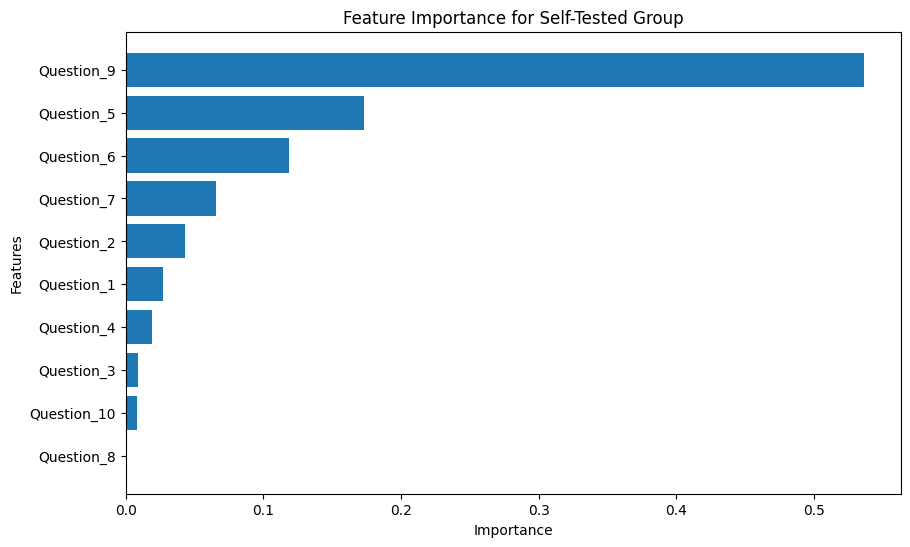

--------------------------------------------------
Running Decision Tree for Assisted-Tested Group...
Pruned Decision Tree Results for Assisted-Tested Group:
Accuracy: 0.8503 ± 0.0472
Precision: 0.6033 ± 0.3056
Recall: 0.6400 ± 0.3441
F1-Score: 0.6133 ± 0.3110
--------------------------------------------------
Feature Importance (Pruned Tree):
Question_1: 0.0000
Question_2: 0.0000
Question_3: 0.1162
Question_4: 0.0000
Question_5: 0.0585
Question_6: 0.0186
Question_7: 0.0000
Question_8: 0.0646
Question_9: 0.6123
Question_10: 0.1298


/Users/shadunts/.pyenv/versions/3.9.7/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


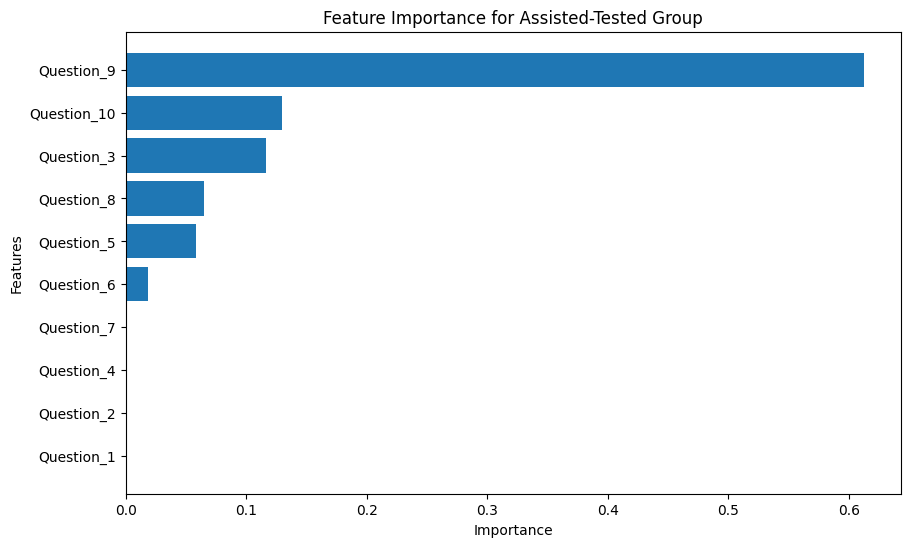

--------------------------------------------------


In [10]:
def decision_tree_cv_with_pruning(data, group_name):
    X = data[features]
    y = data[target]

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Add pruning constraints: max_depth and min_samples_split
    model = DecisionTreeClassifier(max_depth=4, min_samples_split=5, random_state=42)

    accuracy = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
    precision = cross_val_score(model, X, y, cv=skf, scoring='precision')
    recall = cross_val_score(model, X, y, cv=skf, scoring='recall')
    f1 = cross_val_score(model, X, y, cv=skf, scoring='f1')

    model.fit(X, y)
    feature_importance = model.feature_importances_

    print(f"Pruned Decision Tree Results for {group_name} Group:")
    print(f"Accuracy: {np.mean(accuracy):.4f} ± {np.std(accuracy):.4f}")
    print(f"Precision: {np.mean(precision):.4f} ± {np.std(precision):.4f}")
    print(f"Recall: {np.mean(recall):.4f} ± {np.std(recall):.4f}")
    print(f"F1-Score: {np.mean(f1):.4f} ± {np.std(f1):.4f}")
    print("-" * 50)
    print("Feature Importance (Pruned Tree):")
    for feature, importance in zip(features, feature_importance):
        print(f"{feature}: {importance:.4f}")
    # Visualization for Feature Importance
    plt.figure(figsize=(10, 6))
    sorted_idx = np.argsort(feature_importance)  # Sort features by importance
    plt.barh(np.array(features)[sorted_idx], feature_importance[sorted_idx])
    plt.title(f"Feature Importance for {group_name} Group")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.show()
    print("-" * 50)

# Run Decision Tree for Self-Tested and Assisted-Tested groups
print("Running Decision Tree for Self-Tested Group...")
decision_tree_cv_with_pruning(self_tested_data, "Self-Tested")

print("Running Decision Tree for Assisted-Tested Group...")
decision_tree_cv_with_pruning(assisted_tested_data, "Assisted-Tested")

### Pruned Decision Tree Results: Self-Tested vs Assisted-Tested Groups

#### **1. Performance for Self-Tested Group**

**Feature Importance**:  
- `Question_9`: **0.5364**  
- `Question_5`: **0.1732**  
- `Question_6`: **0.1187**  

**Observation**:  
- Accuracy and Recall decreased slightly compared to the unpruned tree, indicating better generalization and reduced overfitting.
- `Question_9` remains the dominant feature, followed by `Question_5` and `Question_6`.  
- Pruning effectively reduced the complexity of the tree while maintaining good performance.

---

#### **2. Performance for Assisted-Tested Group**

**Feature Importance**:  
- `Question_9`: **0.6123**  
- `Question_10`: **0.1298**  
- `Question_3`: **0.1162**  

**Observation**:  
- The pruned tree’s performance dropped slightly, particularly in Recall and F1-Score, but variability reduced (lower standard deviation).
- `Question_9` remains the most critical feature, but other features like `Question_10` and `Question_3` also gain importance.  
- The Assisted-Tested group still struggles due to the limited dataset size, as reflected in the lower precision and recall.

---

### **Key Comparisons and Insights**
1. **Performance Gap**:
   - The Self-Tested group outperforms the Assisted-Tested group in all metrics.
   - The Assisted-Tested group’s Recall remains low, indicating difficulty in capturing positive cases.

2. **Feature Importance**:
   - **`Question_9`** consistently emerges as the most important feature for both groups.  
   - For the Assisted-Tested group, `Question_10` and `Question_3` contribute more significantly after pruning.

3. **Impact of Pruning**:
   - Pruning successfully reduced overfitting and simplified the model at the cost of a small accuracy drop.  
   - This trade-off ensures better generalization, especially for smaller datasets like the Assisted-Tested group.

---

## Random Forest

Running Random Forest for Self-Tested Group...
Random Forest Cross-Validation Results for Self-Tested Group:
Accuracy: 0.9520 ± 0.0299
Precision: 0.9245 ± 0.0552
Recall: 0.9167 ± 0.0597
F1-Score: 0.9196 ± 0.0496
--------------------------------------------------
Feature Importance:
Question_1: 0.0434
Question_2: 0.0585
Question_3: 0.0582
Question_4: 0.1025
Question_5: 0.1891
Question_6: 0.2283
Question_7: 0.0449
Question_8: 0.0289
Question_9: 0.2070
Question_10: 0.0391


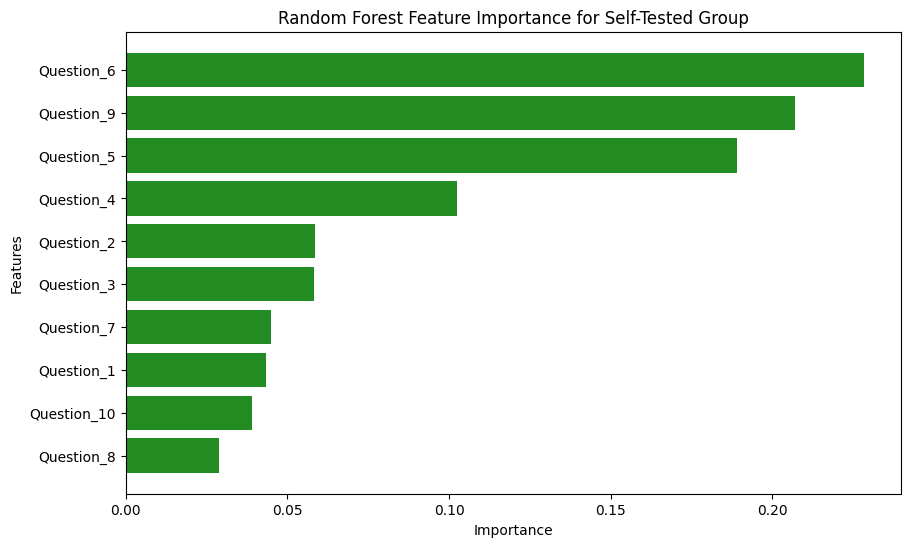

--------------------------------------------------
Running Random Forest for Assisted-Tested Group...
Random Forest Cross-Validation Results for Assisted-Tested Group:
Accuracy: 0.9196 ± 0.0279
Precision: 0.8529 ± 0.1232
Recall: 0.8700 ± 0.1077
F1-Score: 0.8500 ± 0.0544
--------------------------------------------------
Feature Importance:
Question_1: 0.0520
Question_2: 0.0349
Question_3: 0.0648
Question_4: 0.0975
Question_5: 0.0932
Question_6: 0.1360
Question_7: 0.0753
Question_8: 0.0663
Question_9: 0.3182
Question_10: 0.0619


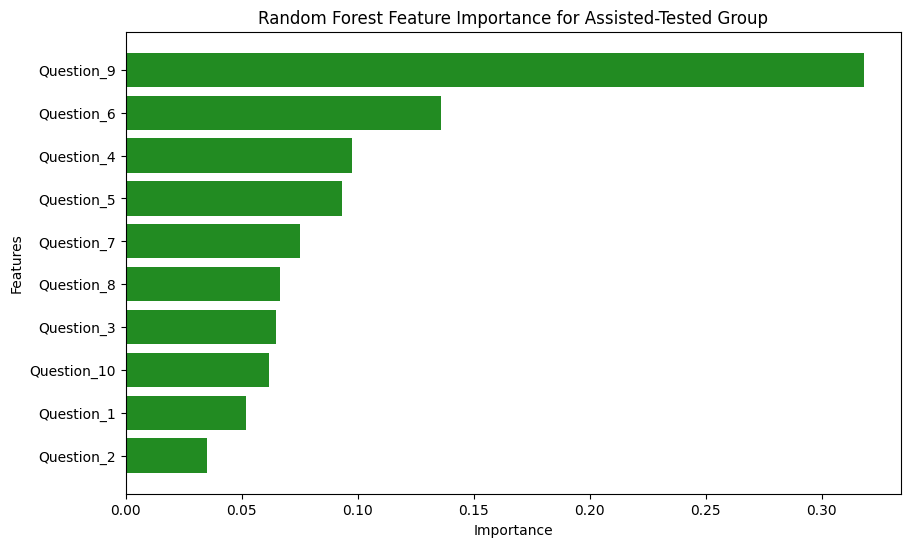

--------------------------------------------------


In [12]:
# function to train and evaluate Random Forest with Cross-Validation
def random_forest_cv(data, group_name):
    X = data[features]
    y = data[target]
    
    # Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Initialize Random Forest with hyperparameters
    model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    
    # Cross-validation for metrics
    accuracy = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
    precision = cross_val_score(model, X, y, cv=skf, scoring='precision')
    recall = cross_val_score(model, X, y, cv=skf, scoring='recall')
    f1 = cross_val_score(model, X, y, cv=skf, scoring='f1')
    
    # Train model on full dataset to analyze feature importance
    model.fit(X, y)
    feature_importance = model.feature_importances_
    
    # Display results
    print(f"Random Forest Cross-Validation Results for {group_name} Group:")
    print(f"Accuracy: {np.mean(accuracy):.4f} ± {np.std(accuracy):.4f}")
    print(f"Precision: {np.mean(precision):.4f} ± {np.std(precision):.4f}")
    print(f"Recall: {np.mean(recall):.4f} ± {np.std(recall):.4f}")
    print(f"F1-Score: {np.mean(f1):.4f} ± {np.std(f1):.4f}")
    print("-" * 50)
    print("Feature Importance:")
    for feature, importance in zip(features, feature_importance):
        print(f"{feature}: {importance:.4f}")
    plt.figure(figsize=(10, 6))
    sorted_idx = np.argsort(feature_importance)  # Sort features by importance
    plt.barh(np.array(features)[sorted_idx], feature_importance[sorted_idx], color="forestgreen")
    plt.title(f"Random Forest Feature Importance for {group_name} Group")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.savefig(os.path.join(output_folder, f"random_forest-{group_name}.png"),  bbox_inches='tight')
    plt.show()
    plt.close()
    print("-" * 50)

# Run Random Forest for Self-Tested and Assisted-Tested groups
print("Running Random Forest for Self-Tested Group...")
random_forest_cv(self_tested_data, "Self-Tested")

print("Running Random Forest for Assisted-Tested Group...")
random_forest_cv(assisted_tested_data, "Assisted-Tested")


### Random Forest Results: Self-Tested vs Assisted-Tested Groups

#### **1. Performance for Self-Tested Group**

**Feature Importance**:
- `Question_6`: **0.2283**
- `Question_9`: **0.2070**
- `Question_5`: **0.1891**

**Observations**:
- The Self-Tested model achieves high accuracy and balanced Precision-Recall, indicating reliable predictions.
- **`Question_6`**, **`Question_9`**, and **`Question_5`** are the top contributors, showing strong importance in the model's decision-making.

---

#### **2. Performance for Assisted-Tested Group**

**Feature Importance**:
- `Question_9`: **0.3182**
- `Question_6`: **0.1360**
- `Question_4`: **0.0975**

**Observations**:
- The Assisted-Tested group also performs well but with slightly lower precision and higher variability compared to the Self-Tested group.
- **`Question_9`** remains the dominant predictor, followed by **`Question_6`** and **`Question_4`**.

---

### **Key Comparisons**
1. **Performance**:
   - The Self-Tested group outperforms the Assisted-Tested group in both accuracy and precision.
   - Both models perform well overall, suggesting that Random Forest effectively generalizes patterns in both datasets.

2. **Feature Importance**:
   - **`Question_9`** consistently emerges as the most influential feature across both groups.
   - The Self-Tested group highlights `Question_6` and `Question_5` as additional key contributors.
   - The Assisted-Tested group emphasizes `Question_6` and `Question_4` in addition to `Question_9`.

3. **Impact of Sample Size**:
   - The Assisted-Tested group, with fewer samples, shows higher variability in precision and recall across folds.

---

### **Insights**
- **Question Dominance**: `Question_9` is critical for both groups, making it a strong candidate for deeper analysis.
- Random Forest shows robustness and better generalization compared to Decision Trees, particularly for smaller datasets like the Assisted-Tested group.


## SVM

Running SVM for Self-Tested Group...
SVM Cross-Validation Results for Self-Tested Group:
Accuracy: 1.0000 ± 0.0000
Precision: 1.0000 ± 0.0000
Recall: 1.0000 ± 0.0000
F1-Score: 1.0000 ± 0.0000
--------------------------------------------------


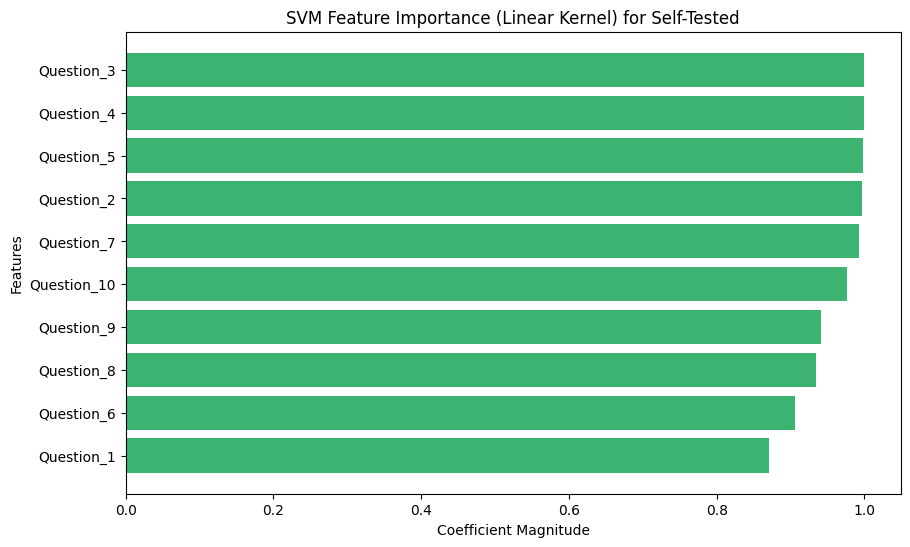

--------------------------------------------------


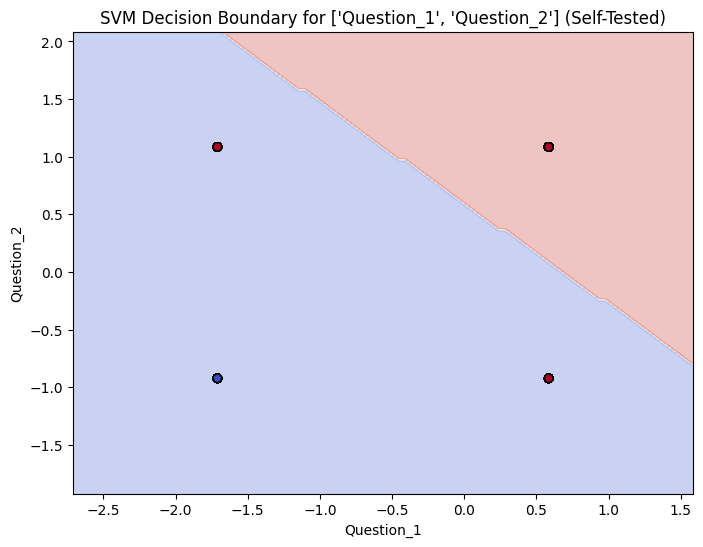

Running SVM for Assisted-Tested Group...
SVM Cross-Validation Results for Assisted-Tested Group:
Accuracy: 0.9431 ± 0.0352
Precision: 0.9429 ± 0.1143
Recall: 0.8700 ± 0.1077
F1-Score: 0.8937 ± 0.0571
--------------------------------------------------


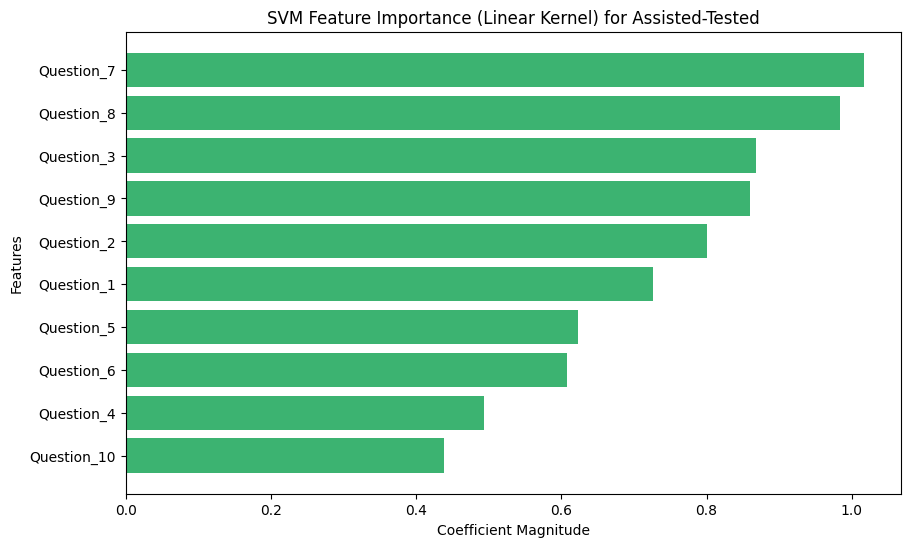

--------------------------------------------------


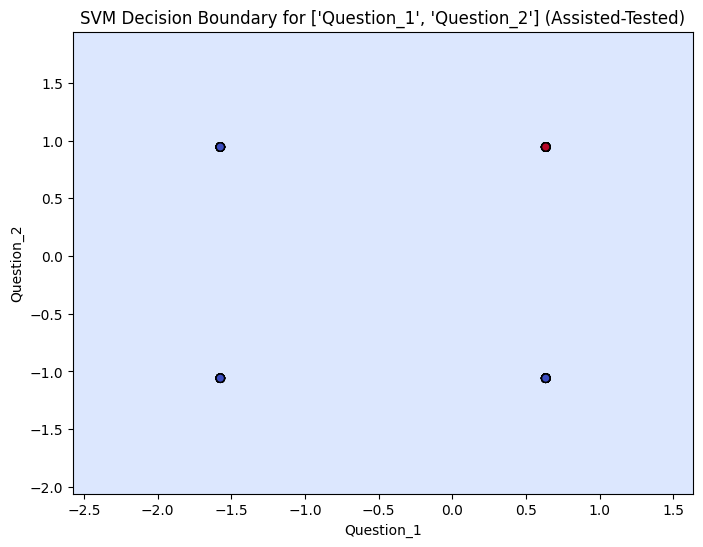

In [25]:
# Function to train, evaluate, and visualize SVM results
def svm_cv(data, group_name):
    X = data[features]
    y = data[target]
    
    # Standardize features (important for SVM)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Initialize Linear SVM
    model = SVC(kernel="linear", random_state=42)
    
    # Cross-validation for metrics
    accuracy = cross_val_score(model, X_scaled, y, cv=skf, scoring='accuracy')
    precision = cross_val_score(model, X_scaled, y, cv=skf, scoring='precision')
    recall = cross_val_score(model, X_scaled, y, cv=skf, scoring='recall')
    f1 = cross_val_score(model, X_scaled, y, cv=skf, scoring='f1')
    
    # Train model on full dataset
    model.fit(X_scaled, y)
    
    # Display results
    print(f"SVM Cross-Validation Results for {group_name} Group:")
    print(f"Accuracy: {np.mean(accuracy):.4f} ± {np.std(accuracy):.4f}")
    print(f"Precision: {np.mean(precision):.4f} ± {np.std(precision):.4f}")
    print(f"Recall: {np.mean(recall):.4f} ± {np.std(recall):.4f}")
    print(f"F1-Score: {np.mean(f1):.4f} ± {np.std(f1):.4f}")
    print("-" * 50)

    # Visualization: Approximate feature importance using coefficients
    if model.kernel == "linear":
        plt.figure(figsize=(10, 6))
        coef = np.abs(model.coef_[0])
        sorted_idx = np.argsort(coef)
        plt.barh(np.array(features)[sorted_idx], coef[sorted_idx], color="mediumseagreen")
        plt.title(f"SVM Feature Importance (Linear Kernel) for {group_name}")
        plt.xlabel("Coefficient Magnitude")
        plt.ylabel("Features")
        plt.savefig(os.path.join(output_folder, f"svm_feature_importance-{group_name}.png"),  bbox_inches='tight')
        plt.show()
        plt.close()
    print("-" * 50)

    # Decision Boundary Visualization (for two features)
    if len(features) >= 2:
        feature_subset = features[:2]
        X_2d = X[feature_subset]
        X_2d_scaled = scaler.fit_transform(X_2d)
        model.fit(X_2d_scaled, y)

        plt.figure(figsize=(8, 6))
        x_min, x_max = X_2d_scaled[:, 0].min() - 1, X_2d_scaled[:, 0].max() + 1
        y_min, y_max = X_2d_scaled[:, 1].min() - 1, X_2d_scaled[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
        plt.scatter(X_2d_scaled[:, 0], X_2d_scaled[:, 1], c=y, edgecolors='k', cmap="coolwarm")
        plt.title(f"SVM Decision Boundary for {feature_subset} ({group_name})")
        plt.xlabel(feature_subset[0])
        plt.ylabel(feature_subset[1])
        plt.savefig(os.path.join(output_folder, f"svm_decision_boundary-{group_name}.png"),  bbox_inches='tight')
        plt.show()
        plt.close()

# Run SVM for Self-Tested and Assisted-Tested groups
print("Running SVM for Self-Tested Group...")
svm_cv(self_tested_data, "Self-Tested")

print("Running SVM for Assisted-Tested Group...")
svm_cv(assisted_tested_data, "Assisted-Tested")

### Interpretation of SVM Results:

#### Self-Tested Group:
1. **Model Performance**:
   - The model shows perfect performance for the self-tested group, likely due to a simpler decision boundary or a clean separation in the feature space.

2. **Feature Importance**:
   - **Questions 3, 4, 5, 2, and 7** had the highest coefficient magnitudes, indicating they contributed the most to classification in the SVM model.

3. **Decision Boundary Visualization**:
   - A decision boundary was plotted using **Question_1** and **Question_2** as features.
   - The boundary clearly separates the classes (0 and 1), demonstrating a clean division for the self-tested group.

---

#### Assisted-Tested Group:
1. **Model Performance**:
   - **Accuracy**: 94.3%
   - **Precision**: 94.3%
   - **Recall**: 87.0%
   - **F1-Score**: 89.4%
   - While the performance is strong, it is slightly lower compared to the self-tested group, suggesting more variability or overlap in the data for assisted individuals.

2. **Feature Importance**:
   - **Questions 7, 8, 3, and 9** were the most important features for classifying the assisted-tested group, as indicated by the coefficient magnitudes.

3. **Decision Boundary Visualization**:
   - A similar decision boundary was plotted for **Question_1** and **Question_2**.
   - The boundary is less clean compared to the self-tested group, indicating a more complex feature distribution in this group.

---

### Summary:
- **Self-Tested Group**: Perfect model performance indicates clear separability in responses.
- **Assisted-Tested Group**: Slightly lower performance reflects variability in assisted-test responses.
- Feature importances differ between the two groups, which may explain differences in the classification complexity.


| **Algorithm**        | **Group**           | **Accuracy**      | **Precision**     | **Recall**        | **F1-Score**      |
|-----------------------|---------------------|-------------------|-------------------|-------------------|-------------------|
| Logistic Regression   | Self-Tested         | 99.81% ± 0.38%    | 99.38% ± 1.25%    | 100.00% ± 0.00%   | 99.68% ± 0.63%    |
| Logistic Regression   | Assisted-Tested     | 96.54% ± 2.83%    | 100.00% ± 0.00%   | 87.00% ± 10.77%   | 92.70% ± 6.07%    |
| Decision Tree         | Self-Tested         | 93.28% ± 3.17%    | 85.29% ± 6.35%    | 94.21% ± 5.56%    | 89.41% ± 5.10%    |
| Decision Tree         | Assisted-Tested     | 87.32% ± 2.50%    | 79.62% ± 11.41%   | 77.00% ± 27.50%   | 72.67% ± 16.38%   |
| Random Forest         | Self-Tested         | 95.20% ± 2.99%    | 92.45% ± 5.52%    | 91.67% ± 5.97%    | 91.96% ± 4.96%    |
| Random Forest         | Assisted-Tested     | 91.96% ± 2.79%    | 85.29% ± 12.32%   | 87.00% ± 10.77%   | 85.00% ± 5.44%    |
| SVM                   | Self-Tested         | 100.00% ± 0.00%   | 100.00% ± 0.00%   | 100.00% ± 0.00%   | 100.00% ± 0.00%   |
| SVM                   | Assisted-Tested     | 94.31% ± 3.52%    | 94.29% ± 11.43%   | 87.00% ± 10.77%   | 89.37% ± 5.71%    |


Relation_to_test
Self-Tested        157
Assisted-Tested     23
Name: count, dtype: int64


/var/folders/3q/1dnvg5nn0_73w1fyyj_hk0hc0000gn/T/ipykernel_29949/1327284387.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=asd_counts.index, y=asd_counts.values, palette='coolwarm')


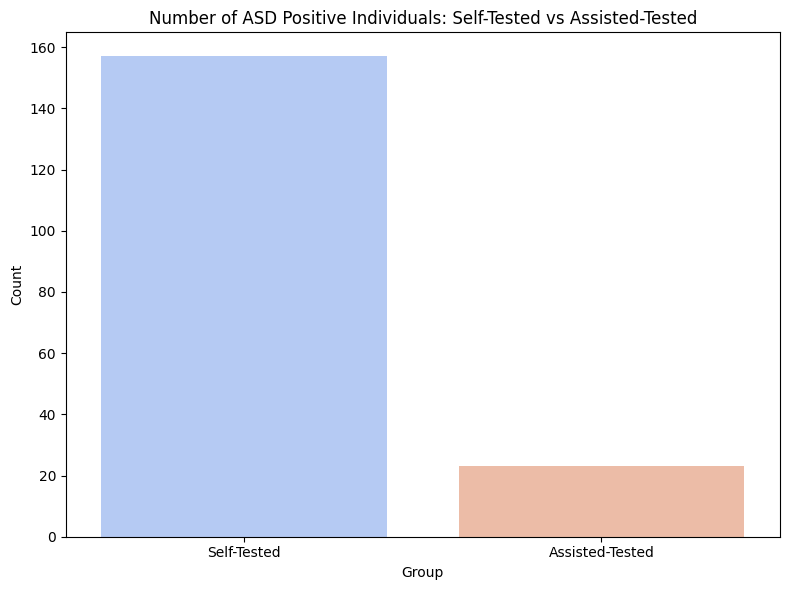

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data where ASD_Class == 1
asd_positive = df[df['ASD_Class'] == 1]

# Group by Relation_to_test (Self-Tested vs Assisted-Tested) and count
asd_counts = asd_positive['Relation_to_test'].apply(lambda x: 'Self-Tested' if x == 'Self' else 'Assisted-Tested').value_counts()
print(asd_counts)

# Create a bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=asd_counts.index, y=asd_counts.values, palette='coolwarm')

# Add chart details
plt.title('Number of ASD Positive Individuals: Self-Tested vs Assisted-Tested')
plt.xlabel('Group')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "asd_class_bar_chart.png"),  bbox_inches='tight')
plt.show()
plt.close()

# ASD_Class distribution (0 = No ASD, 1 = ASD) for Assisted-Tested
# plt.figure(figsize=(8, 6))
# sns.countplot(x='ASD_Class', data=assisted_tested, palette='muted')
# plt.title('ASD Classification for Assisted-Tested Group')
# plt.xlabel('ASD_Class (0 = No ASD, 1 = ASD)')
# plt.ylabel('Count')
# plt.tight_layout()
# plt.savefig(os.path.join(output_folder, "asd_class_bar_chart.png"),  bbox_inches='tight')
# plt.show()
# plt.close()

# Compare Ethnicity of Assisted-Tested Group
# plt.figure(figsize=(8, 5))
# sns.countplot(y='ethnicity', data=assisted_tested, palette='husl', order=assisted_tested['ethnicity'].value_counts().index)
# plt.title('Ethnicity Distribution for Assisted-Tested Group')
# plt.xlabel('Count')
# plt.ylabel('Ethnicity')
# plt.tight_layout()
# plt.show()
